In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [73]:
#torch data set
class dataSetAll(Dataset):
    def __init__(self, yearLow, yearHigh,numFeat,numOut):
        #import data from CDC
        self.df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
        self.df = self.df[(yearLow <= self.df["YEAR"]) & (self.df["YEAR"] < yearHigh)]["TOTAL"]
        #turn data into features and output
        #features: 5 previous + one from last year for predicted
        #output: prediction for next time

        #create test data
        self.numFeat = numFeat #------------------------
        self.numOut = numOut
        self.data = np.asarray(self.df,dtype=np.float32)
        self.data = torch.as_tensor(self.data)

    def __len__(self):
        return len(self.data)-self.numFeat-self.numOut
    
    def __getitem__(self,idx):
        return self.data[idx:idx+self.numFeat],self.data[idx+self.numFeat+self.numOut-1]

In [74]:
#create data loaders
numFeat = 5
numOut = 1
train_data = dataSetAll(1900,2013,numFeat,numOut)
test_data = dataSetAll(2013,2100,numFeat,numOut)
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [75]:
# create our RNN based network with an RNN followed by a linear layer
inputSize = 1
sequenceLength = numFeat
numLayers = 1
hiddenSize = 64
batchSize = 64

class RNN(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers, numOut, sequenceLength=1):
        super(RNN, self).__init__()
        self.numOut = numOut
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.numLayers = numLayers
        self.RNN = nn.GRU(inputSize,hiddenSize,numLayers,batch_first=True)
        self.fc = nn.Linear(hiddenSize*sequenceLength,1)
        
    def forward(self,x):
        h0 = torch.zeros(self.numLayers,x.size(0),self.hiddenSize)
        out, _ = self.RNN(x,h0)
        out = self.fc(out[:,-1,:])
        return out

model = RNN(inputSize,hiddenSize,numLayers,numOut)

In [76]:
#train/test loop
def train_loop(dataloader, model, loss_fn, optimizer,t):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X[:,:,None]
        # print(X.size())
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)
        # print("pred",pred)
        # print("Y",y)
        # Backpropagation
        model.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss({t}): {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return pred

In [77]:
learning_rate = .005
batch_size = 64
epochs = 1000
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# print(list(model.parameters()))
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    pred = train_loop(train_dataloader, model, loss_fn, optimizer,t)
    # test_loop(test_dataloader, model, loss_fn)

print("Done!")
# print(pred)
# print(list(model.parameters()))

loss(0): 7581362.500000  [    0/  787]
loss(1): 8713268.000000  [    0/  787]
loss(2): 8419337.000000  [    0/  787]
loss(3): 8481168.000000  [    0/  787]
loss(4): 8296507.000000  [    0/  787]
loss(5): 8496945.000000  [    0/  787]
loss(6): 8637730.000000  [    0/  787]
loss(7): 8569614.000000  [    0/  787]
loss(8): 8707007.000000  [    0/  787]
loss(9): 8620138.000000  [    0/  787]
loss(10): 8538552.000000  [    0/  787]
loss(11): 8471464.000000  [    0/  787]
loss(12): 8415243.000000  [    0/  787]
loss(13): 8367190.500000  [    0/  787]
loss(14): 8325316.000000  [    0/  787]
loss(15): 8288168.000000  [    0/  787]
loss(16): 8254660.000000  [    0/  787]
loss(17): 8224007.500000  [    0/  787]
loss(18): 8195631.500000  [    0/  787]
loss(19): 8169087.000000  [    0/  787]
loss(20): 8144072.000000  [    0/  787]
loss(21): 8120334.000000  [    0/  787]
loss(22): 8097711.000000  [    0/  787]
loss(23): 8076053.000000  [    0/  787]
loss(24): 8055257.500000  [    0/  787]
loss(25): 

KeyboardInterrupt: 

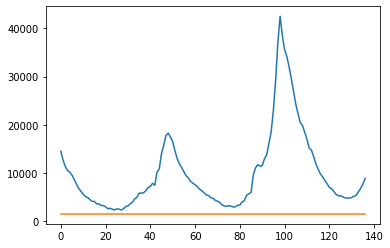

In [ ]:
def test_loop(dataloader, model):
    yearLow = 2013
    yearHigh = 2020
    df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
    df = df[(yearLow <= df["YEAR"]) & (df["YEAR"] < yearHigh)]["TOTAL"]
    data = np.array(df)
    numFeat = 10 #------------------------
    numOut = 1

    size = len(data)-numFeat-numOut
    
    with torch.no_grad():
        for idx in range(4,len(test_data)):
            feat = test_data[idx][0]
            y = test_data[idx][1]
            X = feat[None,:,None]
            pred = model(X).squeeze().numpy()
            plt.plot(np.append(feat,pred))
            plt.plot(np.append(feat,y))
            
            plt.show()
            

def graph(model):
    with torch.no_grad():
        predY = []
        actY = []
        for idx in range(len(test_data)):
            feat = test_data[idx][0]
            y = test_data[idx][1]
            X = feat[None,:,None]
            pred = model(X).squeeze().numpy()
            predY.append(pred)
            actY.append(y)
            # plt.plot(np.append(feat,pred))
            # plt.plot(np.append(feat,y))
            
            
        
        plt.plot(actY) 
        plt.plot(predY)
        plt.show()

graph(model)
# test_loop(test_dataloader,model)
